<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:200%;
           font-family:Arial;letter-spacing:0.5px">

<p width = 20%, style="padding: 10px;
              color:white;">
Ensemble Learning: Bagging and Random Forests
              
</p>
</div>

Data Science Cohort Live NYC Nov 2022
<p>Phase 3: Topic 30</p>
<br>
<br>

<div align = "right">
<img src="Images/flatiron-school-logo.png" align = "right" width="200"/>
</div>
    
    

In [2]:
import numpy as np
import pandas as pd
import xlrd
import os
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV,\
cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier,\
ExtraTreesClassifier, VotingClassifier, StackingRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

#### Motivation:

Kim-Jong-un after using decision tree: launch nukes?

<center><img src = "Images/kimjongun.jpg" width = 700 /></center>

Maybe better to make this a more democratic process with more perspectives on the data:

Other decision makers:

<table><tr><td><img src="Images/mother_teresa.webp" width="250"/><br><center>Mother Theresa</center></td><td><img src="Images/sakharov.jpg" width="200"/><br><center>Andrei Sakharov</center></td><td><img src="Images/cat_press_button.gif" width="300"/><br><center>Nice kitty.</center></td></tr></table>

This thinking applicable to all models:
- particularly useful in the context of Decision Trees

#### Deficiencies of Decision Trees:
- that ensemble learning can address.

Reminder of decision trees: 
- recursively make splits based on entropy or impurity
- split on feature best increasing information gain
- Keep splitting until leaf pure OR max depth

<img src = "Images/dec_tree_partitioning.jpg" width = 800/>

- Tendency to overfit at large max depth.
- High enough depth: will fit to training set perfectly.

<img src = "Images/dectree_perfectfit.png" />
<center> A perfect fit to the training set. </center>

<img src = "Images/decisiontree_classification_overfitting.png"  />
<center> Some more decision tree overfitting </center>

Too much **variance**.

To avoid: reduce decision tree depth to limit variance.
    
But with decision tree, will easily end up underfitting.

- Can increase depth again to get better:
    - But very likely to learn a boundary that overfits

<img src = "Images/dectree_underfitting.png" width = 400/>

Bias-variance problem is severe with Decision Tree models:
- Very sensitive to tree depth.

A very nice visualization of this sensitivity on the regression task:
<img src = "Images/decision_tree_regression.png" />

**Decision trees not-robust**:

- Criterion is harsh: choose *single* feature that wins and split on that.
- But many features may be important in a region and should be factored in.

<img src = "Images/tree_features.png" />
Both Culmen length and depth matter here. But split for each region considers only one or the other.

- Doesn't reflect the way features are related to each other and collectively impact the target.


**Can we figure out a way in a split for a given subregion to factor in different features?**


Depending on goal could be nice if modeling target-feature function:
- without feature engineering.
- without distributional assumptions

#### Another issue:

- Recursion: after split on "best" feature, different subsets never talk to each other again.
- But maybe other branches/regions: info influencing split/class assignment in given subregion.

<img src = "Images/dec_tree_partitioning.jpg" width =500/>
<center>Choosing next split: black or orange?</center>

**Perhaps sampling/factoring in different regions?**

Increasing depth and number of splits:
- Very quickly: small number of points in given sub-region
- Feature decision very sensitive to points in specific region.

<img src = "Images/data_points.png" width = 200 />
<center> Plausible small subregion with few points </center>

Two possible choices (equivalent in terms of impurity):

<img src = "Images/data_points_splt1.png" width = 200 />

<img src = "Images/data_points_splt2.png" width = 200 />

Decision boundary instability: 
- small changes/fluctuations in data lead to very different decision surface locally.

<img src = "Images/data_points_splt1_inst.png" width =400/>

<img src = "Images/data_points_splt2_inst.png" width =400/>

How to get around this?

Don't want to rely too heavily on specific data points and their location:
- Maybe introducing randomness in data point sampling in some way.

#### Why am I using decision trees at all then?

#### Decision trees are blindingly fast.
- Recursion on binary trees
- Greedy criterion:
    - always split on best feature at local node

**Want to keep this speed and still use trees**

But also want to:
- Sample other features when making splits
- Sample other regions in feature-space when making decisions on class assignments


- Learn from classifiers training on different realizations of the dataset:
    - a set of given points has different weight/importance in each realization

Way to create realization of dataset with different weights for data: 
- **Bagging (boostrap aggregation)**

<center><img src = "Images/sample_bagging_only.png" width = 1000/></center>

<center><img src = "Images/sample_bagging_only.png"/></center>

The boostrap:

- N samples in training set.
- Randomly resample training set **with replacement** N times.
- Resampled set also has N samples.

A given point now has different weight/importance in each realization

More explicitly: see training point reweighting under bootstrapping

In [3]:
# (feature, label) pairs
train = np.array([(-1,1), (3.1, 0) , (-2.5, 1),
         (1, 0), (-4, 1), (.5, 0)])
train

array([[-1. ,  1. ],
       [ 3.1,  0. ],
       [-2.5,  1. ],
       [ 1. ,  0. ],
       [-4. ,  1. ],
       [ 0.5,  0. ]])

In [4]:
from numpy.random import choice
idx_resampled =choice(range(len(train)), 
                      size = len(train),
                       replace = True)
train[idx_resampled]

array([[-4. ,  1. ],
       [-1. ,  1. ],
       [-2.5,  1. ],
       [-2.5,  1. ],
       [-1. ,  1. ],
       [-2.5,  1. ]])

#### Now use ensemble of trained models
- Aggregate to make prediction on test data

<center><img src = "Images/bagging_classifier.png" width = 900/></center>

In the context of regression:
- aggregation function is average of regressor trees

<center><img src = "Images/bagging_regressor.png"width = 900 /></center>

The concept of bagging of estimators is **NOT** limited to trees:
- can use any classifier or regressor and perform bagging procedures.
- but mainly useful for local models like DecisionTree or KNN


To implement bagging classifier in sklearn:

In [5]:
# if doing classification
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# if doing regression
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

We'll do classification:
- Predict diabetes via health stats
- Pima Indian diabetes dataset

In [6]:
diab_df = pd.read_csv('Data/diabetes.csv')
diab_df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [7]:
diab_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [8]:
diab_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


- Separate features and target
- Train/test split

In [11]:
# train test split
X = diab_df.drop(columns = ['Outcome'])
y = diab_df['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.15)

Now develop our pipeline.

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix, ConfusionMatrixDisplay

Define the bagging classifier and put it into a pipeline. 

Then integrate into a grid search tuning on tree depth.

In [13]:
bag_class_decision = BaggingClassifier(base_estimator = DecisionTreeClassifier(), n_estimators = 150)
bag_pipe = Pipeline([('scaler', StandardScaler()),
                      ('model',
                       bag_class_decision)])
params = {'model__base_estimator__max_depth': np.arange(4,28,4)}
cv = GridSearchCV(estimator = bag_pipe, param_grid = params, cv = 5)

In [15]:
cv.fit(X_train, y_train);

Get best model and its balanced accuracy

In [16]:
best_model = cv.best_estimator_
cv.best_params_

{'model__base_estimator__max_depth': 20}

In [17]:
cv.best_score_

0.771614797416324

In [18]:
pd.DataFrame(cv.cv_results_)[['param_model__base_estimator__max_depth', 'mean_test_score', 'std_test_score']]

,param_model__base_estimator__max_depth,mean_test_score,std_test_score
0,4,0.766999,0.052532
1,8,0.766999,0.049332
2,12,0.770065,0.040633
3,16,0.763958,0.047990
4,20,0.771615,0.048567
5,24,0.763911,0.039654


Fit the best model. Get predictions and report.

In [19]:
best_model.fit(X_train, y_train);

In [20]:
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.83      0.81        76
           1       0.64      0.57      0.61        40

    accuracy                           0.74       116
   macro avg       0.71      0.70      0.71       116
weighted avg       0.74      0.74      0.74       116



Is bagging better than baseline decision tree over the same range of tree depths?

In [21]:
simpletree_pipe = Pipeline([('scaler', StandardScaler()),
                      ('model',
                       DecisionTreeClassifier())]) 

params = {'model__max_depth': np.arange(4,28,4)}

cvtree = GridSearchCV(estimator = simpletree_pipe, param_grid = params, cv = 5)

cvtree.fit(X_train, y_train);

In [22]:
best_simplemodel = cvtree.best_estimator_
cvtree.best_params_

{'model__max_depth': 4}

In [23]:
cvtree.best_score_

0.7178860833822667

Classification report

In [24]:
best_simplemodel.fit(X_train, y_train)
y_pred_simple = best_simplemodel.predict(X_test)
print(classification_report(y_test, y_pred_simple))

              precision    recall  f1-score   support

           0       0.72      0.87      0.79        76
           1       0.58      0.35      0.44        40

    accuracy                           0.69       116
   macro avg       0.65      0.61      0.61       116
weighted avg       0.67      0.69      0.67       116



A bit worse on the precision/recall for all classes -- especially positive class. 
- In many cases improvements on bagging alone will not be so significant.
- Sample bagging alone usually not enough to capture feature space.

Reason: 
- boostrapped samples are still highly correlated with each other

#### Final ingredient (first set of strategies)

- Effectively factor in other features when making splits
- Sample other regions in feature-space when making decisions on class assignments

Can effectively do this by considering only a random subset of features to split on at each node



Result: each tree may partition feature space in appreciably different ways.

<img src = "Images/rf_splitting.png"  width = 900/>

Overall effect of this:

<img src = "Images/indtree.gif"  width = 600/>

- Each decision tree can learn different important features to make splits on throughout feature space.
- Each tree can assign a given feature region to different classes based on its splits.

Individual trees making errors but **different** errors.


<img src = "Images/rfplot.gif"  width = 600/>

- Aggregating smooths large fluctuations of class assignments from individual trees out.
- Due to feature subset sampling: can learn more complex boundaries: smoothens these.
- Can also get probability of class assignment.

Import RandomForestClassifier

In [25]:
from sklearn.ensemble import RandomForestClassifier

Let's try out of the box.

In [26]:
rf_pipe = Pipeline([('scaler', StandardScaler()),
                      ('model',
                       RandomForestClassifier(n_estimators = 100))])

In [27]:
rf_pipe.fit(X_train, y_train);

In [28]:
y_rf_pred = rf_pipe.predict(X_test)

In [29]:
print(classification_report(y_test, y_rf_pred))

              precision    recall  f1-score   support

           0       0.78      0.86      0.82        76
           1       0.67      0.55      0.60        40

    accuracy                           0.75       116
   macro avg       0.72      0.70      0.71       116
weighted avg       0.74      0.75      0.74       116



#### Better than bagging and base Decision Tree.

#### Should tune model: understand relevant hyperparameters
- understand parameters of model

- n_estimators: number of trees in forest (very important):
    - optimal will depend on dataset size. But 50-250 is good starting tuning range.
- max_features: number of features to randomly sample at each node for evaluating split criterion.
    - good starting value (also default) is $\sqrt{M}$ where $M$ is number of features. (theoretical justification for this)

- max_depth: tree depth
    - due to randomizing and averaging: random forest not as sensitive to this as DecisionTree.
    - default is None. Trains tree to leaf purity. Typically don't touch this.

- min_sample_leaf: minimum number of samples required to be at a leaf node.
    - Default is 1 but having larger numbers can mean averaging effect from leaf
    - Higher values can have a regularizing effect.
    - Typically tune from 1-100 (depends on size of data)

For min sample leaf criterion: cuts out different portions of tree.

<img src = "Images/min_sample_leaf.png" />

Can also change objective functions:
- Gini
- entropy

Grid Search CV on our random forest:

In [30]:
rf_params = {'model__n_estimators': [50, 100, 200, 500] ,
             'model__min_samples_leaf': [1,3,5,7]}
rf_cv = GridSearchCV(estimator = rf_pipe, param_grid = rf_params, cv = 5)
rf_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', RandomForestClassifier())]),
             param_grid={'model__min_samples_leaf': [1, 3, 5, 7],
                         'model__n_estimators': [50, 100, 200, 500]})

In [31]:
rf_cv.best_score_

0.7746330005871991

In [32]:
rf_cv.best_params_

{'model__min_samples_leaf': 3, 'model__n_estimators': 50}

In [33]:
best_rf_model = rf_cv.best_estimator_
best_rf_model

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 RandomForestClassifier(min_samples_leaf=3, n_estimators=50))])

In [34]:
best_rf_model.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 RandomForestClassifier(min_samples_leaf=3, n_estimators=50))])

In [35]:
y_rfcv_pred = best_rf_model.predict(X_test)
print(classification_report(y_test,y_rfcv_pred))

              precision    recall  f1-score   support

           0       0.79      0.89      0.84        76
           1       0.73      0.55      0.63        40

    accuracy                           0.78       116
   macro avg       0.76      0.72      0.73       116
weighted avg       0.77      0.78      0.77       116



OK this is pretty decent. There is also another nice thing about random forests:

Can see which features are most important in prediction:

- .feature_importances_

In [36]:
feat_imp = best_rf_model['model'].feature_importances_

feat_imp_series = pd.Series(feat_imp, 
          index = X.columns).sort_values(
    ascending = False)

In [37]:
feat_imp_series

Glucose                     0.310611
BMI                         0.162355
Age                         0.130226
DiabetesPedigreeFunction    0.118174
Pregnancies                 0.080045
BloodPressure               0.079019
Insulin                     0.064118
SkinThickness               0.055452
dtype: float64

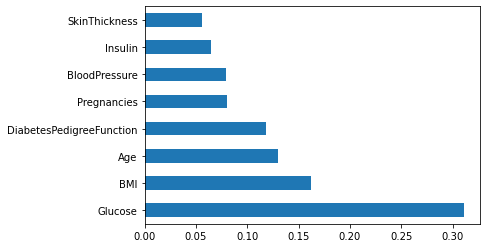

In [38]:
feat_imp_series.plot(kind = 'barh');

Evaluates feature importance:
- Determining for each tree how many times feature was used for splitting.
- Counts up occurences across entire forest and weights features.

#### Extremely Randomized Trees (Extra Trees)
- Sometimes our variance problems are extreme.
- Random forest taking way too long with too many estimators.

- Might want even one more randomization. 
- Instead of always choosing the *optimal* split at node:
    - randomly sample feature space inside node. 
    - split on best information gain from random sample.



Now **three** levels of randomization: 
- sampling of data
- sampling of features
- random selection of branching paths.

Let's import it and do our magic:

In [46]:
from sklearn.ensemble import ExtraTreesClassifier

In [47]:
# Instantiate an ExtraTreesClassifier

etc = ExtraTreesClassifier(max_features='sqrt',
                         max_samples=0.5,
                         bootstrap=True,
                         random_state=1)

In [48]:
# Fit it
etc.fit(X_train, y_train)

ExtraTreesClassifier(bootstrap=True, max_features='sqrt', max_samples=0.5,
                     random_state=1)

In [49]:
# Cross-validation
scores = cross_val_score(estimator=etc, X=X_train, y=y_train, cv=5)
scores

array([0.70229008, 0.76335878, 0.76923077, 0.76923077, 0.76153846])

In [50]:
np.median(scores)

0.7633587786259542

In [51]:
# Score on test
etc.score(X_test, y_test)

0.8017241379310345

Evaluate on the test set

In [52]:
y_etc_pred = etc.predict(X_test)
print(classification_report(y_test, y_etc_pred))

              precision    recall  f1-score   support

           0       0.81      0.91      0.86        76
           1       0.77      0.60      0.68        40

    accuracy                           0.80       116
   macro avg       0.79      0.75      0.77       116
weighted avg       0.80      0.80      0.79       116



**Sometimes** the extra randomization can do even better.
- When suffering from variance issues.
- Also ExtraTrees is very very fast:
    - doesn't spend too much time on finding optimal splits.

# Level Up: Stacking


#### Meta-Classifier/Meta-Regressor

- First, we ask several different models to make predictions about the target
- Rather than taking a simple average or vote to determine the outcome, feed these results into a final model that makes the prediction based on the other models’ predictions
- If it seems like we are approaching a neural network...you are correct!

Remember weighted averaging? Stacking is about using DS models to estimate those weights for us. This means we'll have one layer of base estimators and another layer that is "**trained to optimally combine the model predictions to form a new set of predictions**". See [this short blog post](https://blogs.sas.com/content/subconsciousmusings/2017/05/18/stacked-ensemble-models-win-data-science-competitions/) for more.

## Initial Data Prep

In [53]:
wb = xlrd.open_workbook('data/Sales Report.xls',
                        logfile=open(os.devnull, 'w'))

sales = pd.read_excel(wb)
sales = sales.dropna()

In [54]:
sales.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2017-152156,2017-11-08,2017-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2017-152156,2017-11-08,2017-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2017-138688,2017-06-12,2017-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2016-108966,2016-10-11,2016-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2016-108966,2016-10-11,2016-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [55]:
sales.dtypes

Row ID                    int64
Order ID                 object
Order Date       datetime64[ns]
Ship Date        datetime64[ns]
Ship Mode                object
Customer ID              object
Customer Name            object
Segment                  object
Country                  object
City                     object
State                    object
Postal Code             float64
Region                   object
Product ID               object
Category                 object
Sub-Category             object
Product Name             object
Sales                   float64
Quantity                  int64
Discount                float64
Profit                  float64
dtype: object

In [56]:
sales['Category'].value_counts()

Office Supplies    6020
Furniture          2119
Technology         1844
Name: Category, dtype: int64

In [57]:
sales['Sub-Category'].value_counts()

Binders        1523
Paper          1368
Furnishings     957
Phones          888
Storage         845
Art             795
Accessories     773
Chairs          616
Appliances      465
Labels          364
Tables          319
Envelopes       253
Bookcases       227
Fasteners       217
Supplies        190
Machines        115
Copiers          68
Name: Sub-Category, dtype: int64

In [58]:
X_num = sales[['Discount', 'Profit']].columns
X_cat = sales[['Category', 'Sub-Category']].columns

In [59]:
X = sales[['Discount', 'Profit',
          'Category', 'Sub-Category']]
y = sales['Sales']

## Splitting

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Setting Up a Pipeline

In [61]:
numTrans = Pipeline(steps=[
    ('scaler', StandardScaler())
])
catTrans = Pipeline(steps=[
    ('ohe', OneHotEncoder(drop='first',
                          sparse=False))
])

In [62]:
pp = ColumnTransformer(transformers=[
    ('num', numTrans, X_num),
    ('cat', catTrans, X_cat)
])

In [69]:
x_tr_pp = fit_transform(X_train)

NameError: name 'fit_transform' is not defined

In [ ]:
x_test_pp = transform(X_test)

## Setting Up a Stack


In [63]:
estimators = [
    ('lr', LinearRegression()),
    ('knn', KNeighborsRegressor()),
    ('rt', DecisionTreeRegressor())
]

sr = StackingRegressor(estimators)

In [64]:
final_p = Pipeline([('preprocess', pp), ('model', sr)])

In [65]:
final_p.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Discount', 'Profit'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  Index(['Category', 'Sub-Category'], dtype='object'))])),
                ('model',
                 StackingRegressor(estimators=[('lr', LinearRegression()),
                                               ('knn', KNeighborsRegressor()),
                                     

In [66]:
final_p.score(X_test, y_test)

0.8111347193447468

## Comparison with Base Estimators

In [67]:
lr = LinearRegression().fit(X_tr_pp, y_train)
lr.score(X_test_pp, y_test)

NameError: name 'X_tr_pp' is not defined

In [68]:
knn = KNeighborsRegressor().fit(X_tr_pp, y_train)
knn.score(X_test_pp, y_test)

NameError: name 'X_tr_pp' is not defined

In [ ]:
rt = DecisionTreeRegressor().fit(X_tr_pp, y_train)
rt.score(X_test_pp, y_test)